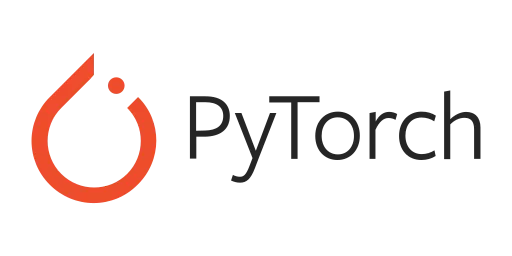

In [1]:
import torch
torch.__version__

'1.11.0+cu113'

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## 선형 회귀 모델(Linear Regression Model)

### 데이터 생성

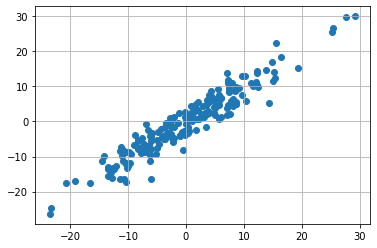

In [4]:
X = torch.randn(200, 1) * 10
y = X + 3 * torch.randn(200, 1)
plt.scatter(X.numpy(), y.numpy())
plt.grid()
plt.show()

### 모델 정의 및 파라미터

In [5]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1,1)

    def forward(self, x):
        pred = self.linear(x)
        return pred

In [6]:
model = LinearRegressionModel()
print(model)
print(list(model.parameters()))

LinearRegressionModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
[Parameter containing:
tensor([[-0.0998]], requires_grad=True), Parameter containing:
tensor([-0.2050], requires_grad=True)]


In [7]:
w, b = model.parameters()
w, b

(Parameter containing:
 tensor([[-0.0998]], requires_grad=True), Parameter containing:
 tensor([-0.2050], requires_grad=True))

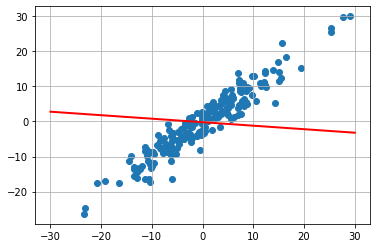

In [8]:
w1, b1 = w[0][0].item(), b[0].item()
x1 = np.array([-30,30])
y1 = w1 * x1 + b1

plt.plot(x1, y1, 'r', lw=2)
plt.scatter(X, y)
plt.grid()
plt.show()

### 손실 함수 및 옵티마이저

In [9]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

### 모델 학습

In [10]:
epochs = 100
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()

    y_pred = model(X)
    loss = criterion(y_pred, y)
    losses.append(loss.item())
    loss.backward()

    optimizer.step()

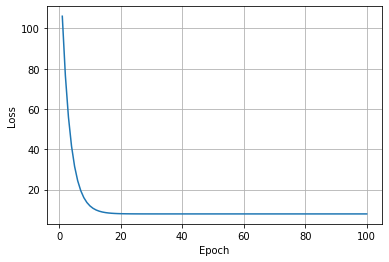

(None, None)

In [11]:
plt.plot(range(1, epochs+1), losses)
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.grid(), plt.show()

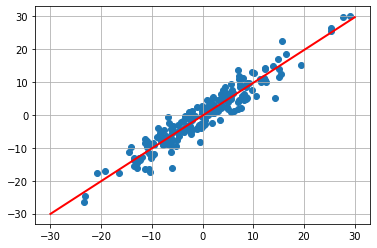

In [12]:
w1, b1 = w[0][0].item(), b[0].item()
x1 = np.array([-30,30])
y1 = w1 * x1 + b1

plt.plot(x1, y1, 'r', lw=2)
plt.scatter(X, y)
plt.grid()
plt.show()

## FashionMNIST 분류 모델

GPU 설정

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### 데이터 로드

In [14]:
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

In [15]:
from torchvision import datasets
trainset = datasets.FashionMNIST(root='/content/',
                                 train=True, download=True,
                                 transform=transform)
testset = datasets.FashionMNIST(root='/content/',
                                 train=False, download=True,
                                 transform=transform)

In [16]:
from torch.utils.data import DataLoader
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

In [17]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [18]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

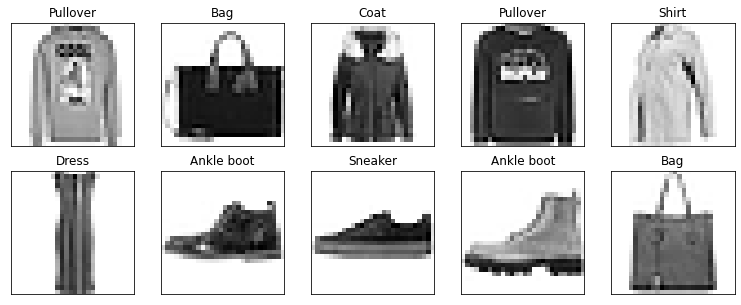

In [19]:
plt.figure(figsize=(13,5))
for i in range(1, 11):
    plt.subplot(2, 5, i)
    image = images[i].squeeze()
    label_idx = labels[i].item()
    plt.imshow(image, cmap='Greys')
    plt.title(class_names[label_idx])
    plt.xticks([]), plt.yticks([])
plt.show()

### 모델 정의 및 파라미터

In [20]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [21]:
net = NeuralNet()
print(net)

NeuralNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [22]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


In [23]:
input = torch.randn(1,1,28,28)
out = net(input)
print(out)

tensor([[-0.0304,  0.0779,  0.0665, -0.0589,  0.0140,  0.0299,  0.0837,  0.1043,
         -0.1614, -0.0857]], grad_fn=<AddmmBackward0>)


### 손실함수와 옵티마이저

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### 모델 학습

배치수 확인

In [25]:
total_batch = len(train_loader)
total_batch

469

In [26]:
for epoch in range(10):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 100 == 99:
            print(f'Epoch: {epoch+1}, Iter: {i+1}, Loss: {running_loss/2000:.6f}')
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.115312
Epoch: 1, Iter: 200, Loss: 0.115295
Epoch: 1, Iter: 300, Loss: 0.115294
Epoch: 1, Iter: 400, Loss: 0.115342
Epoch: 2, Iter: 100, Loss: 0.115355
Epoch: 2, Iter: 200, Loss: 0.115297
Epoch: 2, Iter: 300, Loss: 0.115308
Epoch: 2, Iter: 400, Loss: 0.115368
Epoch: 3, Iter: 100, Loss: 0.115405
Epoch: 3, Iter: 200, Loss: 0.115345
Epoch: 3, Iter: 300, Loss: 0.115308
Epoch: 3, Iter: 400, Loss: 0.115306
Epoch: 4, Iter: 100, Loss: 0.115303
Epoch: 4, Iter: 200, Loss: 0.115308
Epoch: 4, Iter: 300, Loss: 0.115340
Epoch: 4, Iter: 400, Loss: 0.115346
Epoch: 5, Iter: 100, Loss: 0.115335
Epoch: 5, Iter: 200, Loss: 0.115302
Epoch: 5, Iter: 300, Loss: 0.115324
Epoch: 5, Iter: 400, Loss: 0.115297
Epoch: 6, Iter: 100, Loss: 0.115315
Epoch: 6, Iter: 200, Loss: 0.115299
Epoch: 6, Iter: 300, Loss: 0.115283
Epoch: 6, Iter: 400, Loss: 0.115376
Epoch: 7, Iter: 100, Loss: 0.115300
Epoch: 7, Iter: 200, Loss: 0.115354
Epoch: 7, Iter: 300, Loss: 0.115330
Epoch: 7, Iter: 400, Loss: 0

### 모델의 저장 및 로드

- `torch.save`: `net.state_dict()`를 저장
- `torch.load`: `load_state_dict`로 모델을 로드

In [27]:
filepath = 'fashion_mnis.pth'
torch.save(net.state_dict(), filepath)

In [28]:
net2 = NeuralNet()
net2.load_state_dict(torch.load(filepath))

<All keys matched successfully>

In [29]:
net2.parameters

<bound method Module.parameters of NeuralNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)>

### 모델 테스트

In [30]:
def imshow(image):
    image = image / 2 + 0.5
    npimg = image.numpy()

    fig = plt.figure(figsize=(16,4))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

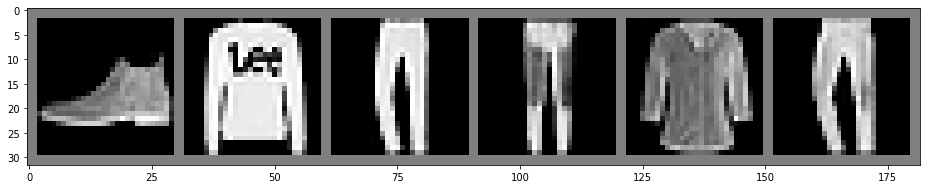

In [31]:
import torchvision
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:6]))

In [32]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7])


In [33]:
print(', '.join(class_names[int(predicted[i].numpy())] for i in range(6)))

Sneaker, Sneaker, Sneaker, Sneaker, Sneaker, Sneaker


In [35]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(100 * correct / total)

9.99
